# Extra dependencies installation

In [1]:
!pip install vit-pytorch
!pip install torchviz
!pip install torchsummary
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=ce52cdfaabf5347b59d8e84c82a2fe60d40ff10da185e598f0fd85dd86605a53
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [2]:
import os
import torch
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import psutil
import h5py
import os
import numpy as np
import time
import copy
from torchsummary import summary
from torch import optim
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from vit_pytorch import ViT
from math import sqrt
import torch
from torch.utils.tensorboard import SummaryWriter

import torch.nn.functional as F
from torch.nn import BCELoss
import torch.optim as pt_optim
import torch.optim.lr_scheduler as pt_lr_scheduler
from torchsummary import summary
import torch.nn as nn
import psutil
import time

from torchviz import make_dot

# Setup dataset 

In [3]:
try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "ML4SCI_GSOC23")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  data_filepath = "data"

photon_file = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

model_save_folder = os.path.join(data_filepath, "models")
tensorboard_save_folder = os.path.join(data_filepath, "tensorboard")

photon_filepath = os.path.join(data_filepath, photon_file)
electron_filepath = os.path.join(data_filepath, electron_file)

electronFile = h5py.File(electron_filepath, "r")
photonFile = h5py.File(photon_filepath, "r")

electronX, electronY = np.array(electronFile.get("X")), np.array(electronFile.get('y'))
photonX, photonY     = np.array(photonFile.get("X")),   np.array(photonFile.get('y'))

mean_electron = np.mean(electronX.reshape(-1, 2), axis=0)
std_electron  = np.std(electronX.reshape(-1, 2), axis=0)
electronX = (electronX - mean_electron) / std_electron

mean_photon   = np.mean(photonX.reshape(-1, 2), axis=0)
std_photon    = np.std(photonX.reshape(-1, 2), axis=0)
photonX = (photonX - mean_electron) / std_electron

class PhotonElectronDataset(Dataset):
    def __init__(self, electron_indexes, photon_indexes, transform=None):
        assert len(electron_indexes) == len(photon_indexes)
        self.electron_indexes = electron_indexes
        self.photon_indexes = photon_indexes
        self.transform = transform

    def __len__(self):
        return len(self.electron_indexes) + len(self.photon_indexes)

    def __getitem__(self, idx):
        #image = torch.from_numpy(self.X[idx, :, :, :])

        # photon if even
        if idx % 2 == 0:
            image = photonX[self.photon_indexes[idx // 2], :, :, :]
            label = photonY[self.photon_indexes[idx // 2]]
        # electron if odd
        else:
            image = electronX[self.electron_indexes[idx // 2], :, :, :]
            label = electronY[self.electron_indexes[idx // 2]]

        if self.transform:
            image = self.transform(image)
        return image, label

Mounted at /content/drive


# EDA 
- just inspect the images, validate whether the dataset is correct

In [4]:
train_size = 0.8
validation_size = 0.1
test_size = 1 - train_size - validation_size

batch_size = 64

nElectronImgs = len(electronFile["X"])
nPhotonImgs = len(photonFile['y'])

electrons_idxs = np.arange(0, nElectronImgs)
np.random.shuffle(electrons_idxs)

photon_idxs = np.arange(0, nPhotonImgs)
np.random.shuffle(photon_idxs)

electron_training_idxs   = electrons_idxs[0: int(train_size * nElectronImgs)]
electron_validation_idxs = electrons_idxs[int(train_size * nElectronImgs) : int((train_size + validation_size) * nElectronImgs)]
electron_test_idxs       = electrons_idxs[int((train_size + validation_size) * nElectronImgs) :]

photon_training_idxs   = photon_idxs[0: int(train_size * nElectronImgs)]
photon_validation_idxs = photon_idxs[int(train_size * nElectronImgs) : int((train_size + validation_size) * nElectronImgs)]
photon_test_idxs       = photon_idxs[int((train_size + validation_size) * nElectronImgs) :]


training_dataset = PhotonElectronDataset(electron_training_idxs, photon_training_idxs, transform=transforms.Compose([transforms.ToTensor()]))
validation_dataset  = PhotonElectronDataset(electron_validation_idxs, photon_validation_idxs, transform=transforms.Compose([transforms.ToTensor()]))
testing_dataset  = PhotonElectronDataset(electron_test_idxs, photon_test_idxs, transform=transforms.Compose([transforms.ToTensor()]))

training_ds_size = len(training_dataset)
validation_ds_size = len(validation_dataset)
testing_ds_size = len(testing_dataset)

print(f"training size : {training_ds_size}")
print(f"validation size : {validation_ds_size}")
print(f"testing size : {testing_ds_size}")

train_dataloader      = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader       = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

training size : 398400
validation size : 49800
testing size : 49800


In [5]:
del photonFile, electronFile
del training_dataset, validation_dataset, testing_dataset

time.sleep(10)
memories = psutil.virtual_memory()
print(f"memory free left : {memories.free / 1000 / 1000 / 1000}Gb ; percentage left {100 - memories.percent}, available : {memories.available / 1000 / 1000 / 1000}")

memory free left : 16.970379263999998Gb ; percentage left 79.0, available : 21.587103744


torch.Size([64, 2, 32, 32])


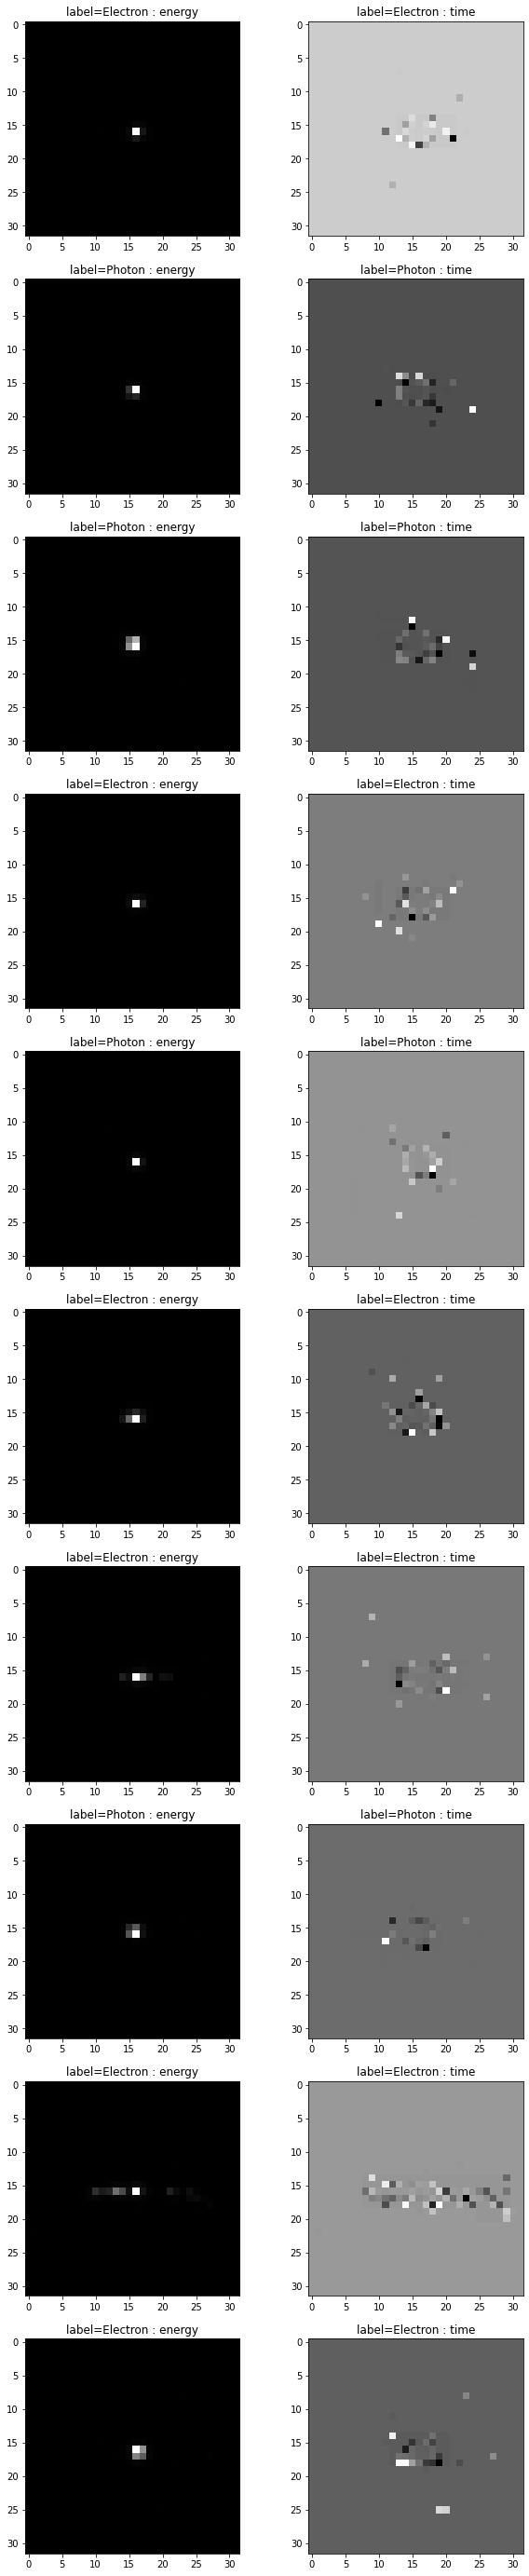

In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape)
label_val_to_text = {1 : "Electron", 0 : "Photon"}

scale = 5
n = int(batch_size)
to_plot = 10
plt.figure(figsize=(2*scale , scale * to_plot))


for y in range(to_plot):
  plt.subplot(to_plot, 2, 2 * y + 1)
  label = label_val_to_text[train_labels[y].item()]
  plt.title(f"label={label} : energy")
  plt.imshow(train_features[y, 0, :, :], cmap='gray')

  plt.subplot(to_plot, 2, 2 * y + 2)
  plt.title(f"label={label} : time")
  plt.imshow(train_features[y, 1, :, :], cmap='gray')


plt.show()

# Pytorch Util functions 

training function and setting up tensorboard for monitoring

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, saveTo, num_epochs=25):
    writer = SummaryWriter(tensorboard_save_folder)
    since = time.time()

    returnDict = {"trainingLoss" : [], "validationLoss" : [], "trainingAccuracy" : [], "validationAccuracy" : [], 
                  "epochs" : [], "trainingAUC" : [], "validationAUC" : []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            since2 = time.time()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            y = torch.Tensor()
            pred_y = torch.Tensor()

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.long()

                y = torch.cat([y, labels.cpu()])
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred_labels = (outputs >= 0.5).reshape(-1)

                    #print(outputs.shape)
                    loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))

                    pred_y = torch.cat([pred_y, outputs.cpu()])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred_labels == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy())  

            if phase == "train":
                returnDict["trainingLoss"].append(epoch_loss)
                returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
                returnDict["trainingAUC"].append(AUC_ROC)
                writer.add_scalar("Loss/train", epoch_loss, epoch)
                writer.add_scalar("Accuracy/train", epoch_acc.cpu().item(), epoch)
                writer.add_scalar("AUC/train", AUC_ROC, epoch)
            else:
                returnDict["validationLoss"].append(epoch_loss)
                returnDict["validationAccuracy"].append(epoch_acc.cpu().item())
                returnDict["validationAUC"].append(AUC_ROC)
                writer.add_scalar("Loss/validation", epoch_loss, epoch)
                writer.add_scalar("Accuracy/validation", epoch_acc.cpu().item(), epoch)
                writer.add_scalar("AUC/validation", AUC_ROC, epoch)


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save({ "state_dict" : model.state_dict()}, saveTo)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    returnDict["best_model"] = model
    writer.close()
    return returnDict

Device Used : cuda:0


In [8]:
def plotResults(results):
    plt.figure(figsize=(16,12))
    plt.subplot(3,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    plt.plot(results['epochs'], results['validationLoss'], label="validation Loss")
    plt.legend()

    plt.subplot(3,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    plt.plot(results['epochs'], results['validationAccuracy'], label="validation Accuracy")
    plt.legend()
  
  
    plt.subplot(3,1, 3)
    plt.plot(results['epochs'], results['trainingAUC'], label="training ROC")
    plt.plot(results['epochs'], results['validationAUC'], label="validation AUC ROC")
    plt.plot([0, results['epochs'][-1]], [0.8, 0.8], "--", color='black')
    plt.legend()

    plt.show()

# Baseline

minimal simple architecture that provide some baseline accuracy

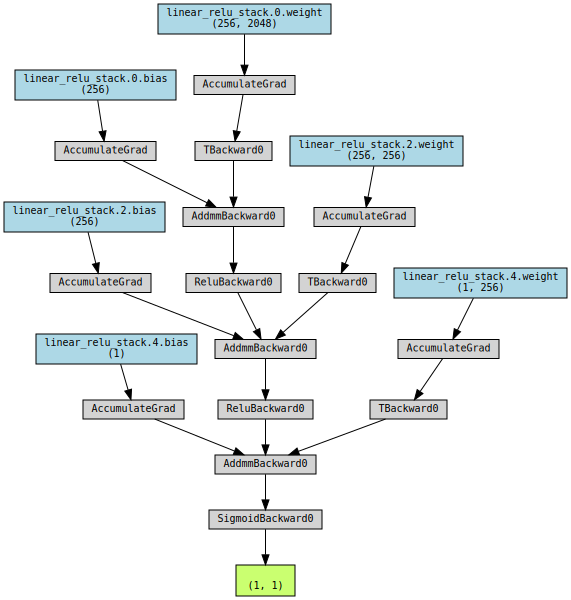

In [ ]:
class BasicNN(nn.Module):
    def __init__(self):
        super(BasicNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2* 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_ft = BasicNN()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(32,32, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2048]               0
            Linear-2                  [-1, 256]         524,544
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 1]             257
           Sigmoid-7                    [-1, 1]               0
Total params: 590,593
Trainable params: 590,593
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 2.25
Estimated Total Size (MB): 2.28
----------------------------------------------------------------


In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "Simple.pt"))

Epoch 0/24
----------
train Loss: 0.6434 Acc: 0.6320 AUC ROC : 0.6740 Time taken : 31.73
val Loss: 0.6285 Acc: 0.6524 AUC ROC : 0.7050 Time taken : 2.12

Epoch 1/24
----------
train Loss: 0.6058 Acc: 0.6780 AUC ROC : 0.7315 Time taken : 28.84
val Loss: 0.6037 Acc: 0.6819 AUC ROC : 0.7346 Time taken : 2.13

Epoch 2/24
----------
train Loss: 0.5813 Acc: 0.7004 AUC ROC : 0.7608 Time taken : 28.82
val Loss: 0.6052 Acc: 0.6846 AUC ROC : 0.7391 Time taken : 2.25

Epoch 3/24
----------
train Loss: 0.5579 Acc: 0.7176 AUC ROC : 0.7850 Time taken : 28.51
val Loss: 0.6084 Acc: 0.6845 AUC ROC : 0.7361 Time taken : 2.24

Epoch 4/24
----------
train Loss: 0.5320 Acc: 0.7346 AUC ROC : 0.8087 Time taken : 28.7
val Loss: 0.6258 Acc: 0.6802 AUC ROC : 0.7295 Time taken : 2.41

Epoch 5/24
----------
train Loss: 0.5064 Acc: 0.7504 AUC ROC : 0.8293 Time taken : 28.48
val Loss: 0.6462 Acc: 0.6800 AUC ROC : 0.7302 Time taken : 2.34

Epoch 6/24
----------
train Loss: 0.4830 Acc: 0.7652 AUC ROC : 0.8466 Time ta

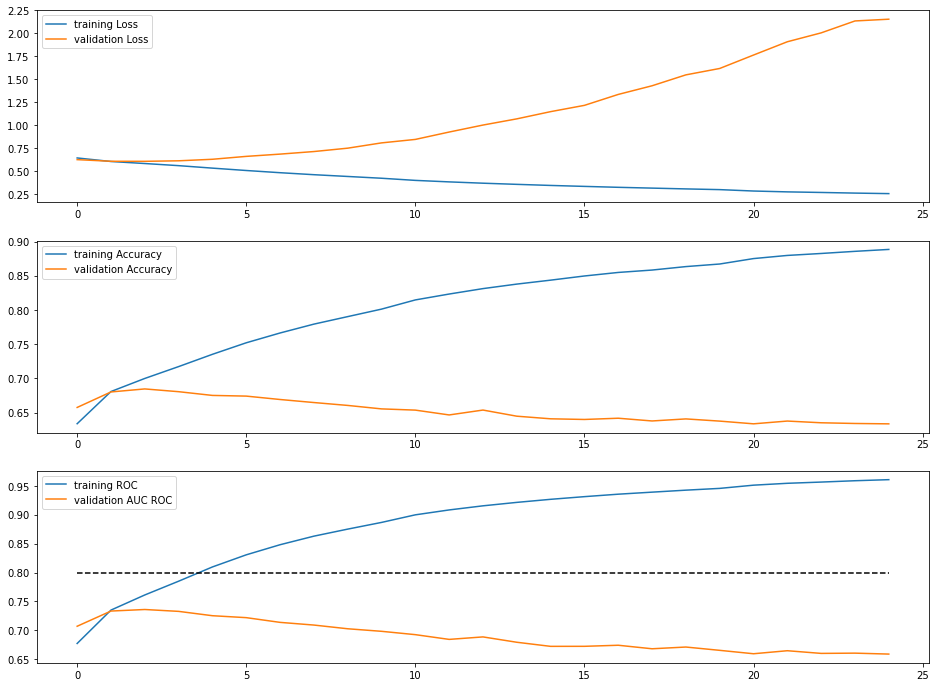

In [ ]:
plotResults(simple_res)

## Analysis
MLP overfits significantly (only in few first epochs we see some improvement for validation dataset, after that significant decay in performance)

# Basic CNN

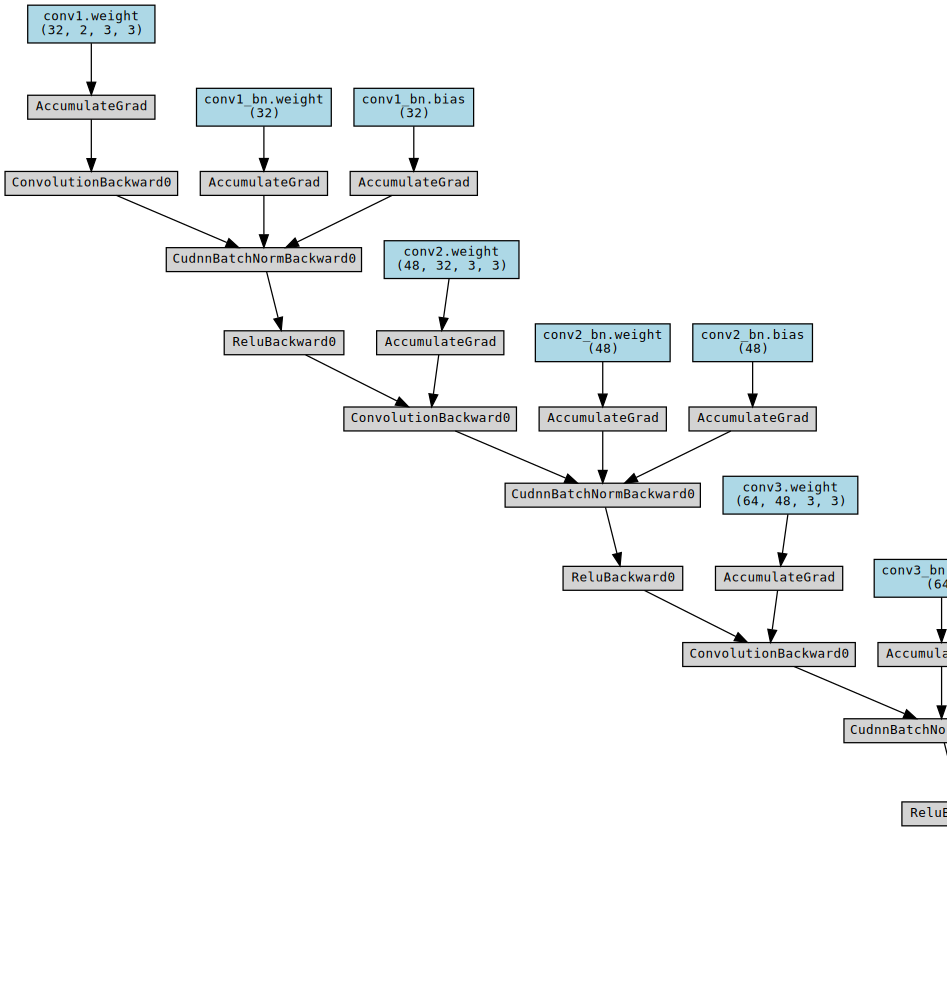

In [ ]:
class ModelM3(nn.Module):
    def __init__(self):
        super(ModelM3, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 80, 3, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(80)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(11520, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.max_pool(conv4)
        flat1 = torch.flatten(conv5.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM3()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             576
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 48, 28, 28]          13,824
       BatchNorm2d-4           [-1, 48, 28, 28]              96
            Conv2d-5           [-1, 64, 26, 26]          27,648
       BatchNorm2d-6           [-1, 64, 26, 26]             128
            Conv2d-7           [-1, 80, 24, 24]          46,080
       BatchNorm2d-8           [-1, 80, 24, 24]             160
         MaxPool2d-9           [-1, 80, 12, 12]               0
           Linear-10                    [-1, 1]          11,520
          Sigmoid-11                    [-1, 1]               0
Total params: 100,096
Trainable params: 100,096
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN.pth"))

Epoch 0/24
----------
train Loss: 0.6243 Acc: 0.6592 AUC ROC : 0.7107 Time taken : 77.71
val Loss: 0.5963 Acc: 0.6913 AUC ROC : 0.7505 Time taken : 3.81

Epoch 1/24
----------
train Loss: 0.5824 Acc: 0.7027 AUC ROC : 0.7611 Time taken : 75.57
val Loss: 2.4088 Acc: 0.5007 AUC ROC : 0.7210 Time taken : 3.84

Epoch 2/24
----------
train Loss: 0.5689 Acc: 0.7133 AUC ROC : 0.7751 Time taken : 75.55
val Loss: 0.5764 Acc: 0.7129 AUC ROC : 0.7753 Time taken : 3.8

Epoch 3/24
----------
train Loss: 0.5621 Acc: 0.7177 AUC ROC : 0.7820 Time taken : 76.01
val Loss: 0.7534 Acc: 0.6287 AUC ROC : 0.7483 Time taken : 4.02

Epoch 4/24
----------
train Loss: 0.5583 Acc: 0.7204 AUC ROC : 0.7856 Time taken : 76.32
val Loss: 0.6017 Acc: 0.7043 AUC ROC : 0.7738 Time taken : 3.84

Epoch 5/24
----------
train Loss: 0.5554 Acc: 0.7225 AUC ROC : 0.7885 Time taken : 76.01
val Loss: 0.5591 Acc: 0.7198 AUC ROC : 0.7870 Time taken : 3.91

Epoch 6/24
----------
train Loss: 0.5526 Acc: 0.7252 AUC ROC : 0.7913 Time ta

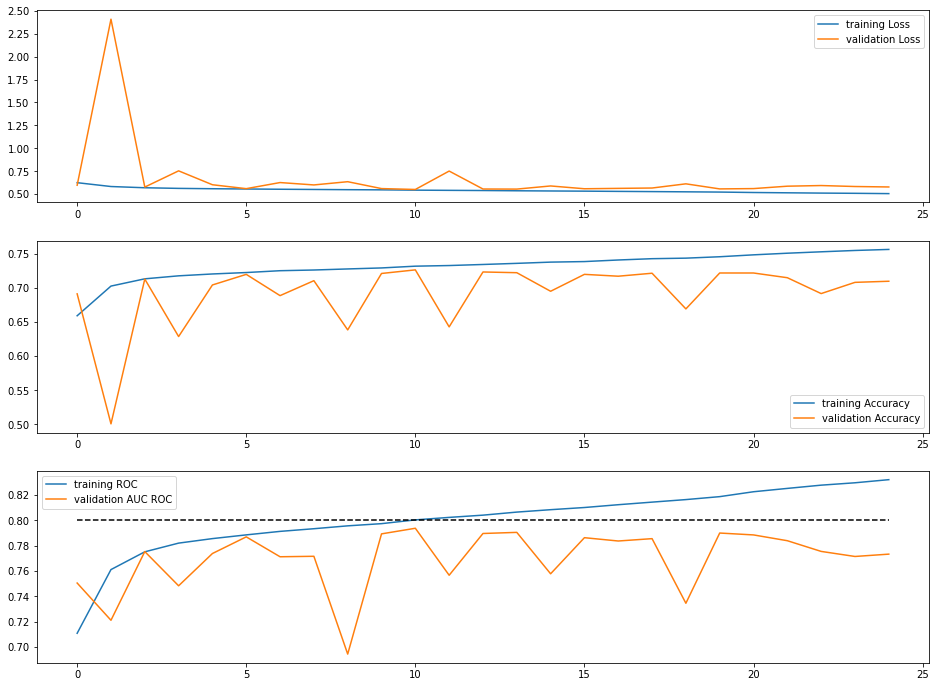

In [ ]:
plotResults(simple_res)

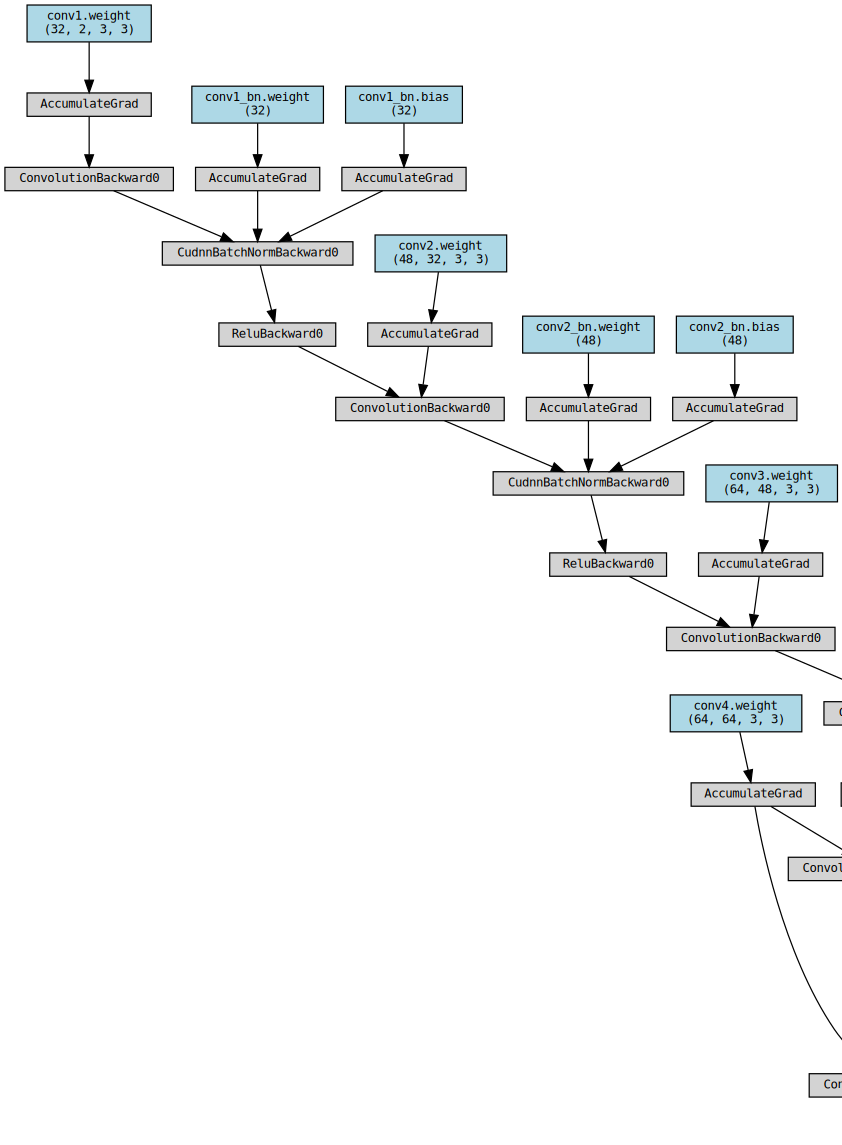

In [ ]:
class ModelM3(nn.Module):
    def __init__(self):
        super(ModelM3, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 18x18
        self.conv5_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(7744, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv4(conv4)))
        max_pool = self.max_pool(conv5)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM3()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             576
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 48, 28, 28]          13,824
       BatchNorm2d-4           [-1, 48, 28, 28]              96
            Conv2d-5           [-1, 64, 26, 26]          27,648
       BatchNorm2d-6           [-1, 64, 26, 26]             128
            Conv2d-7           [-1, 64, 24, 24]          36,864
       BatchNorm2d-8           [-1, 64, 24, 24]             128
            Conv2d-9           [-1, 64, 22, 22]          36,864
      BatchNorm2d-10           [-1, 64, 22, 22]             128
        MaxPool2d-11           [-1, 64, 11, 11]               0
           Linear-12                    [-1, 1]           7,744
          Sigmoid-13                    [-1, 1]               0
Total params: 124,064
Trainable params:

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN2.pth"))

Epoch 0/24
----------
train Loss: 0.6039 Acc: 0.6830 AUC ROC : 0.7359 Time taken : 83.6
val Loss: 3.1312 Acc: 0.5000 AUC ROC : 0.7223 Time taken : 4.25

Epoch 1/24
----------
train Loss: 0.5765 Acc: 0.7075 AUC ROC : 0.7665 Time taken : 84.75
val Loss: 0.5830 Acc: 0.7005 AUC ROC : 0.7714 Time taken : 4.2

Epoch 2/24
----------
train Loss: 0.5658 Acc: 0.7158 AUC ROC : 0.7778 Time taken : 84.36
val Loss: 0.7235 Acc: 0.4851 AUC ROC : 0.4290 Time taken : 4.2

Epoch 3/24
----------
train Loss: 0.5603 Acc: 0.7190 AUC ROC : 0.7834 Time taken : 84.44
val Loss: 0.5972 Acc: 0.6860 AUC ROC : 0.7596 Time taken : 4.33

Epoch 4/24
----------
train Loss: 0.5568 Acc: 0.7222 AUC ROC : 0.7870 Time taken : 85.19
val Loss: 0.5791 Acc: 0.7079 AUC ROC : 0.7750 Time taken : 4.44

Epoch 5/24
----------
train Loss: 0.5534 Acc: 0.7243 AUC ROC : 0.7903 Time taken : 84.88
val Loss: 0.5804 Acc: 0.6993 AUC ROC : 0.7799 Time taken : 4.29

Epoch 6/24
----------
train Loss: 0.5509 Acc: 0.7261 AUC ROC : 0.7926 Time take

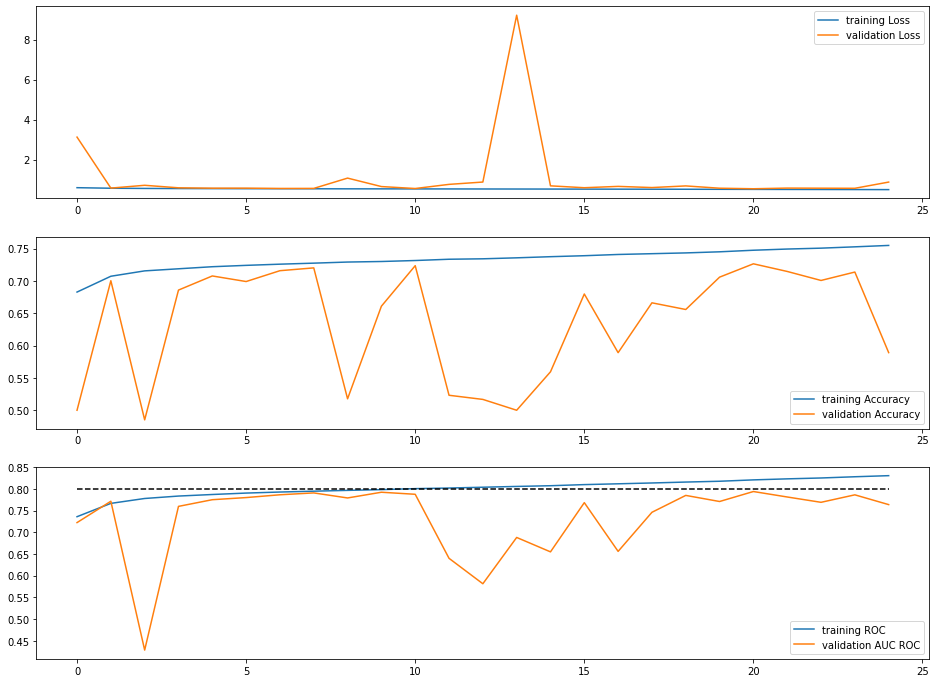

In [ ]:
plotResults(simple_res)

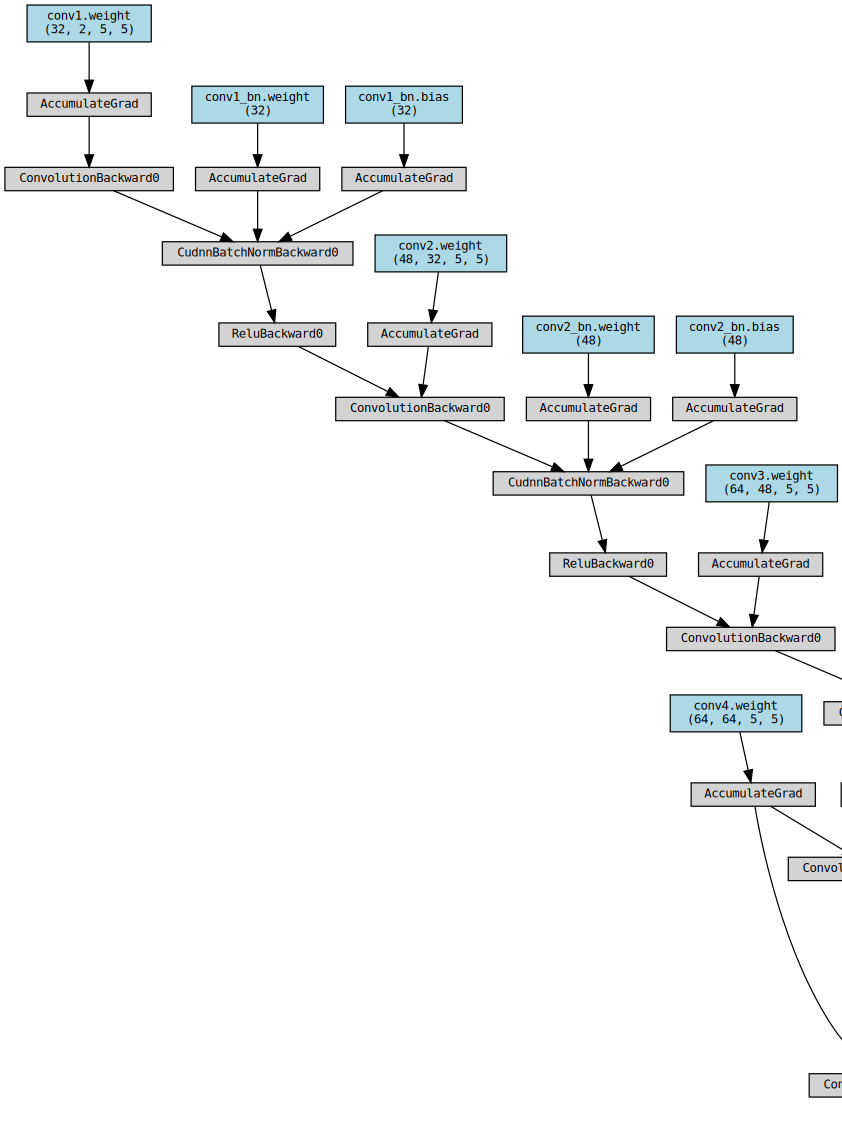

In [ ]:
class ModelM5(nn.Module):
    def __init__(self):
        super(ModelM5, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 5, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 5, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 5, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 18x18
        self.conv5_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(2304, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv4(conv4)))
        max_pool = self.max_pool(conv5)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM5()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           1,600
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 48, 24, 24]          38,400
       BatchNorm2d-4           [-1, 48, 24, 24]              96
            Conv2d-5           [-1, 64, 20, 20]          76,800
       BatchNorm2d-6           [-1, 64, 20, 20]             128
            Conv2d-7           [-1, 64, 16, 16]         102,400
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 12, 12]         102,400
      BatchNorm2d-10           [-1, 64, 12, 12]             128
        MaxPool2d-11             [-1, 64, 6, 6]               0
           Linear-12                    [-1, 1]           2,304
          Sigmoid-13                    [-1, 1]               0
Total params: 324,448
Trainable params:

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))

Epoch 0/24
----------
train Loss: 0.6020 Acc: 0.6812 AUC ROC : 0.7366 Time taken : 67.46
val Loss: 1.5182 Acc: 0.5000 AUC ROC : 0.5537 Time taken : 3.75

Epoch 1/24
----------
train Loss: 0.5677 Acc: 0.7143 AUC ROC : 0.7757 Time taken : 67.72
val Loss: 0.7817 Acc: 0.5084 AUC ROC : 0.7503 Time taken : 3.65

Epoch 2/24
----------
train Loss: 0.5600 Acc: 0.7197 AUC ROC : 0.7838 Time taken : 67.81
val Loss: 0.6247 Acc: 0.6683 AUC ROC : 0.7371 Time taken : 3.69

Epoch 3/24
----------
train Loss: 0.5547 Acc: 0.7238 AUC ROC : 0.7888 Time taken : 67.71
val Loss: 3.3525 Acc: 0.5000 AUC ROC : 0.6736 Time taken : 3.7

Epoch 4/24
----------
train Loss: 0.5513 Acc: 0.7256 AUC ROC : 0.7921 Time taken : 68.12
val Loss: 0.9081 Acc: 0.5181 AUC ROC : 0.5225 Time taken : 3.79

Epoch 5/24
----------
train Loss: 0.5481 Acc: 0.7288 AUC ROC : 0.7952 Time taken : 67.9
val Loss: 0.8154 Acc: 0.5214 AUC ROC : 0.5636 Time taken : 3.71

Epoch 6/24
----------
train Loss: 0.5452 Acc: 0.7306 AUC ROC : 0.7980 Time tak

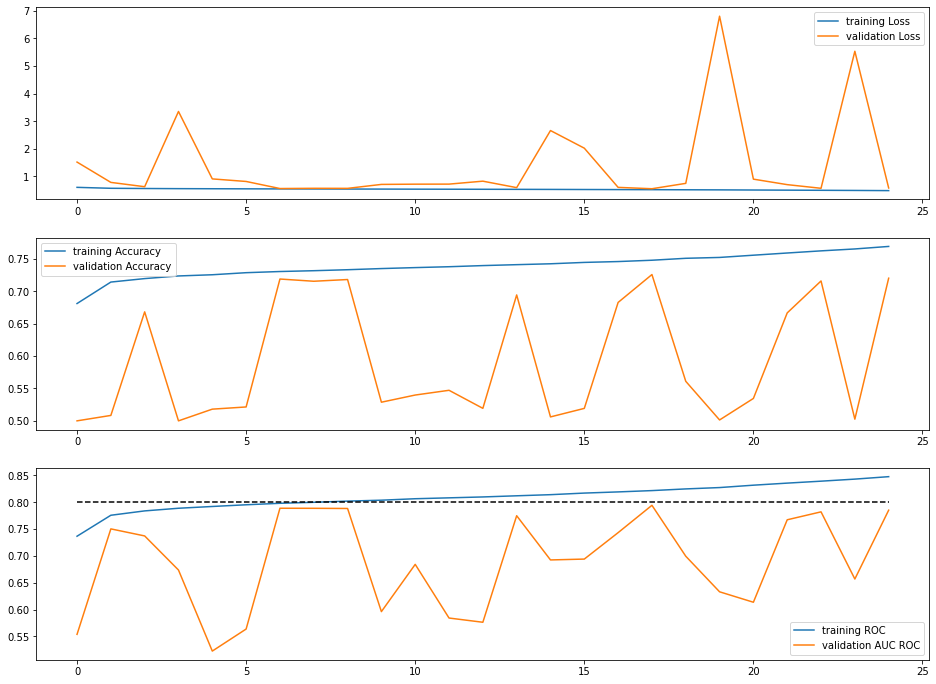

In [ ]:
plotResults(simple_res)

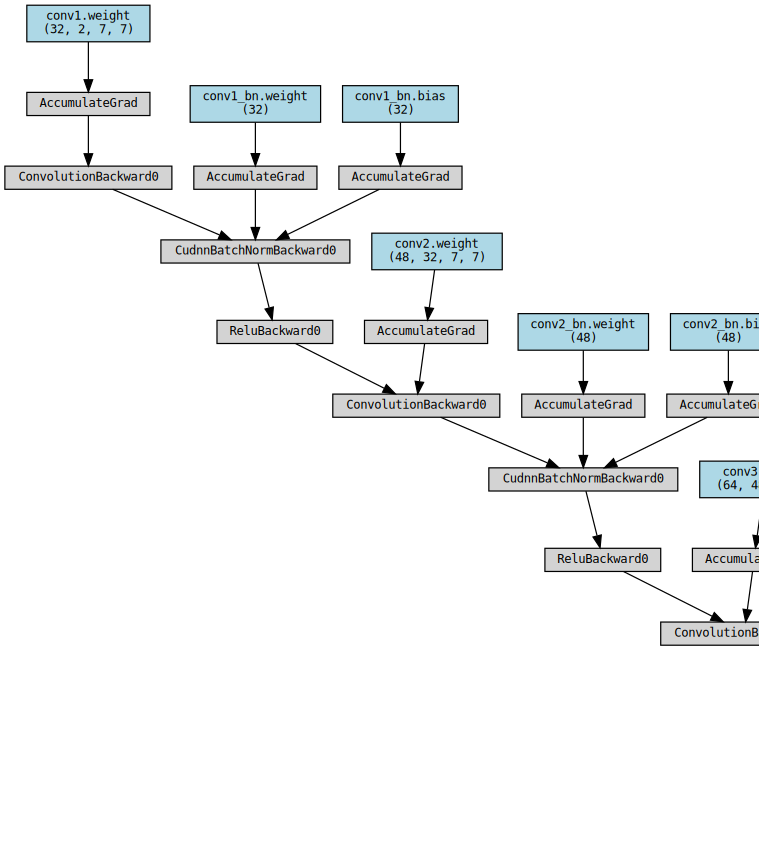

In [ ]:
class ModelM7(nn.Module):
    def __init__(self):
        super(ModelM7, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 7, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 7, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 7, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3136, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        max_pool = self.max_pool(conv3)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM7()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]           3,136
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 48, 20, 20]          75,264
       BatchNorm2d-4           [-1, 48, 20, 20]              96
            Conv2d-5           [-1, 64, 14, 14]         150,528
       BatchNorm2d-6           [-1, 64, 14, 14]             128
         MaxPool2d-7             [-1, 64, 7, 7]               0
            Linear-8                    [-1, 1]           3,136
           Sigmoid-9                    [-1, 1]               0
Total params: 232,352
Trainable params: 232,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.84
Params size (MB): 0.89
Estimated Total Size (MB): 1.73
-------------------------------------------

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))

Epoch 0/24
----------
train Loss: 0.6190 Acc: 0.6608 AUC ROC : 0.7149 Time taken : 45.07
val Loss: 49.9949 Acc: 0.5000 AUC ROC : 0.5000 Time taken : 2.84

Epoch 1/24
----------
train Loss: 0.5719 Acc: 0.7105 AUC ROC : 0.7713 Time taken : 44.98
val Loss: 0.7014 Acc: 0.5168 AUC ROC : 0.5314 Time taken : 2.86

Epoch 2/24
----------
train Loss: 0.5609 Acc: 0.7193 AUC ROC : 0.7827 Time taken : 45.04
val Loss: 0.7918 Acc: 0.5018 AUC ROC : 0.5414 Time taken : 2.84

Epoch 3/24
----------
train Loss: 0.5551 Acc: 0.7238 AUC ROC : 0.7885 Time taken : 45.25
val Loss: 0.6275 Acc: 0.6895 AUC ROC : 0.7717 Time taken : 2.96

Epoch 4/24
----------
train Loss: 0.5501 Acc: 0.7266 AUC ROC : 0.7933 Time taken : 45.0
val Loss: 3.0957 Acc: 0.5004 AUC ROC : 0.4688 Time taken : 2.96

Epoch 5/24
----------
train Loss: 0.5450 Acc: 0.7307 AUC ROC : 0.7983 Time taken : 44.79
val Loss: 0.7522 Acc: 0.5201 AUC ROC : 0.5233 Time taken : 3.07

Epoch 6/24
----------
train Loss: 0.5403 Acc: 0.7335 AUC ROC : 0.8025 Time t

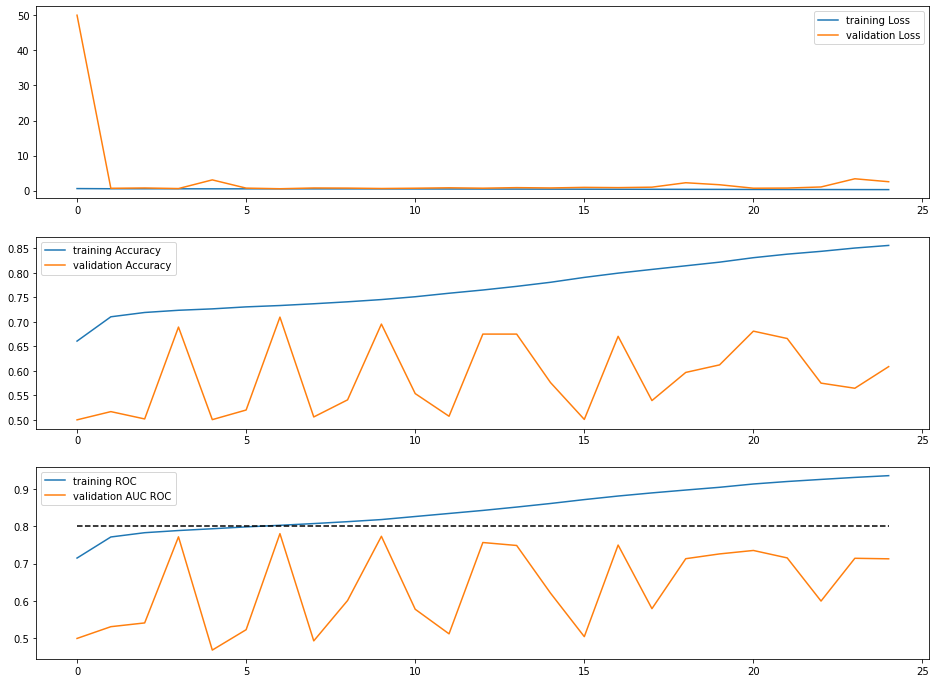

In [ ]:
plotResults(simple_res)

# Even smaller

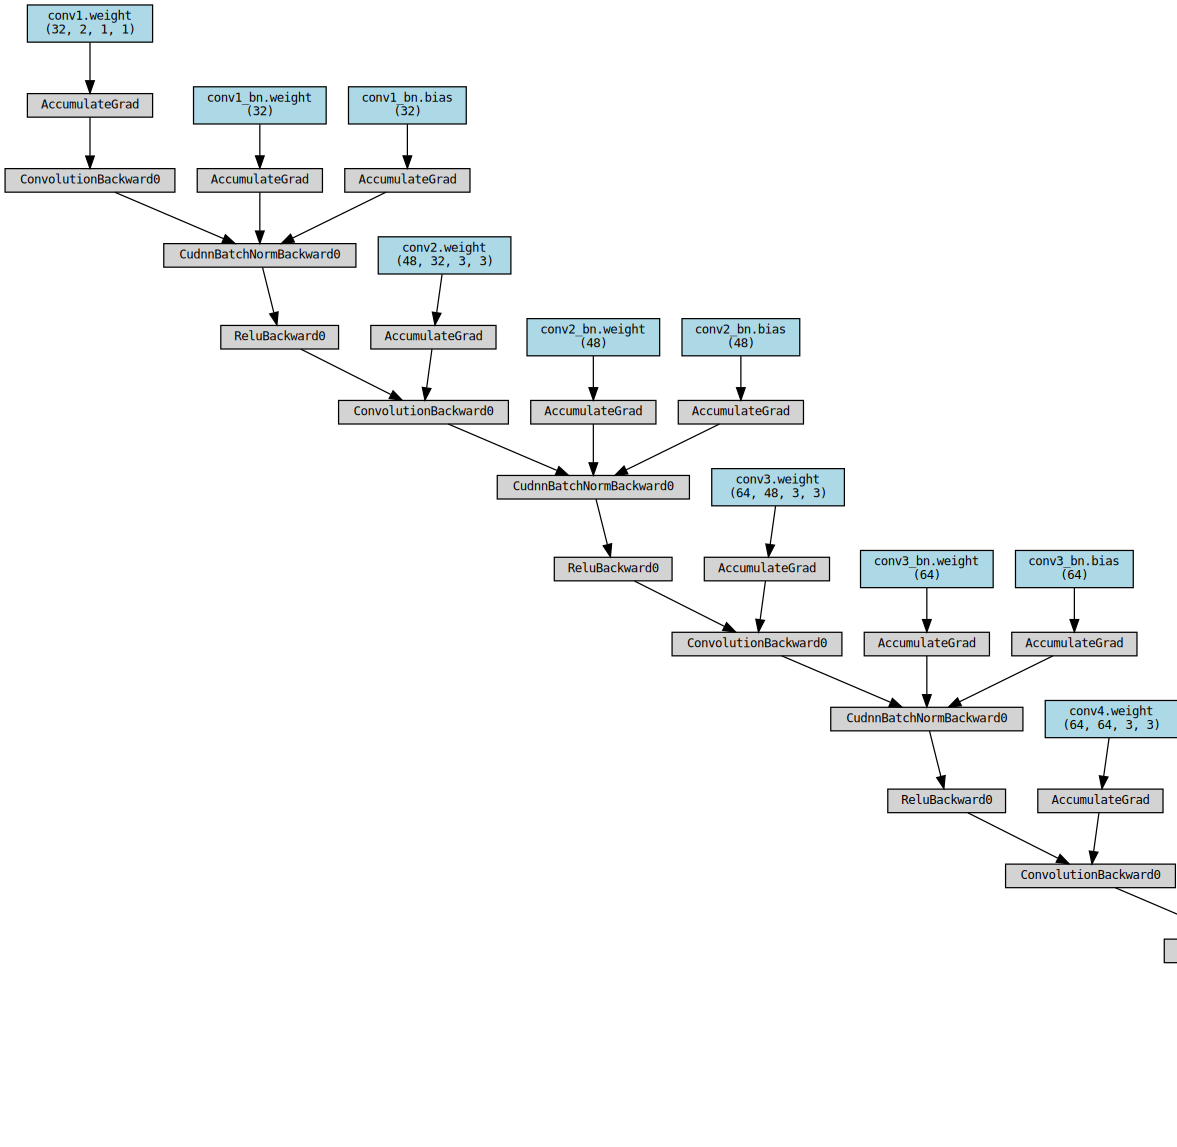

In [ ]:
class ModelM3(nn.Module):
    def __init__(self):
        super(ModelM3, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 18x18
        self.conv5_bn = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 18x18
        self.conv6_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(7744, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv4)))
        
        max_pool = self.max_pool(conv6)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM3()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 48, 30, 30]          13,824
       BatchNorm2d-4           [-1, 48, 30, 30]              96
            Conv2d-5           [-1, 64, 28, 28]          27,648
       BatchNorm2d-6           [-1, 64, 28, 28]             128
            Conv2d-7           [-1, 64, 26, 26]          36,864
       BatchNorm2d-8           [-1, 64, 26, 26]             128
            Conv2d-9           [-1, 64, 24, 24]          36,864
      BatchNorm2d-10           [-1, 64, 24, 24]             128
           Conv2d-11           [-1, 64, 22, 22]         102,400
      BatchNorm2d-12           [-1, 64, 22, 22]             128
        MaxPool2d-13           [-1, 64, 11, 11]               0
           Linear-14                   

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))

Epoch 0/24
----------
train Loss: 0.6079 Acc: 0.6771 AUC ROC : 0.7312 Time taken : 104.78
val Loss: 1.4372 Acc: 0.5000 AUC ROC : 0.7495 Time taken : 5.08

Epoch 1/24
----------
train Loss: 0.5687 Acc: 0.7138 AUC ROC : 0.7750 Time taken : 101.31
val Loss: 0.6346 Acc: 0.6759 AUC ROC : 0.7687 Time taken : 5.13

Epoch 2/24
----------
train Loss: 0.5588 Acc: 0.7202 AUC ROC : 0.7850 Time taken : 101.66
val Loss: 0.5493 Acc: 0.7257 AUC ROC : 0.7942 Time taken : 5.31

Epoch 3/24
----------
train Loss: 0.5533 Acc: 0.7250 AUC ROC : 0.7903 Time taken : 101.28
val Loss: 0.5494 Acc: 0.7266 AUC ROC : 0.7962 Time taken : 5.19

Epoch 4/24
----------
train Loss: 0.5498 Acc: 0.7274 AUC ROC : 0.7936 Time taken : 101.87
val Loss: 0.5466 Acc: 0.7301 AUC ROC : 0.7966 Time taken : 5.17

Epoch 5/24
----------
train Loss: 0.5469 Acc: 0.7293 AUC ROC : 0.7964 Time taken : 101.05
val Loss: 0.5500 Acc: 0.7272 AUC ROC : 0.7982 Time taken : 5.15

Epoch 6/24
----------
train Loss: 0.5439 Acc: 0.7316 AUC ROC : 0.7991 

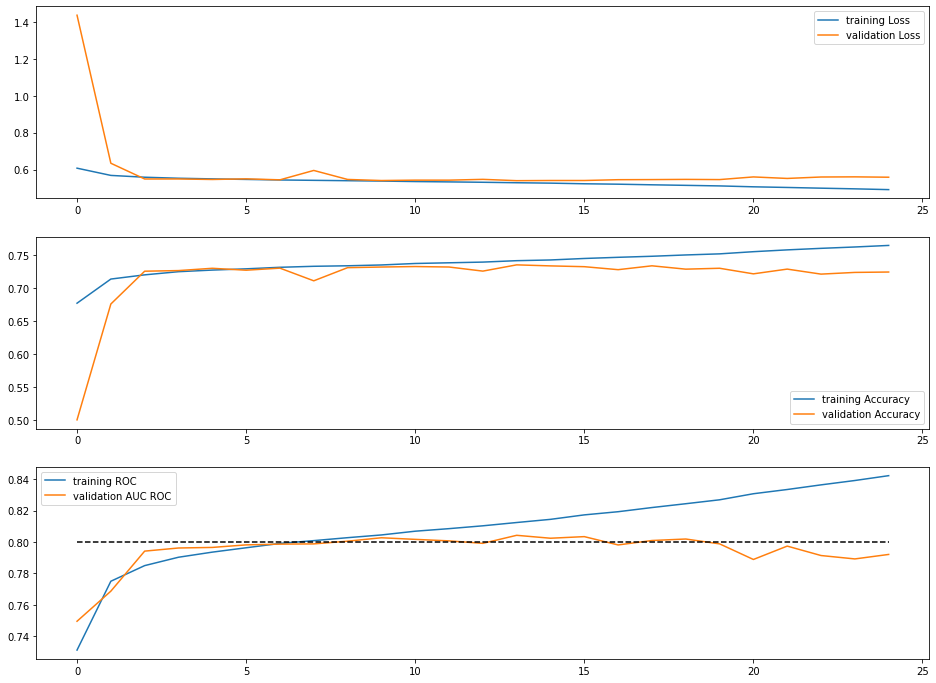

In [ ]:
plotResults(simple_res)

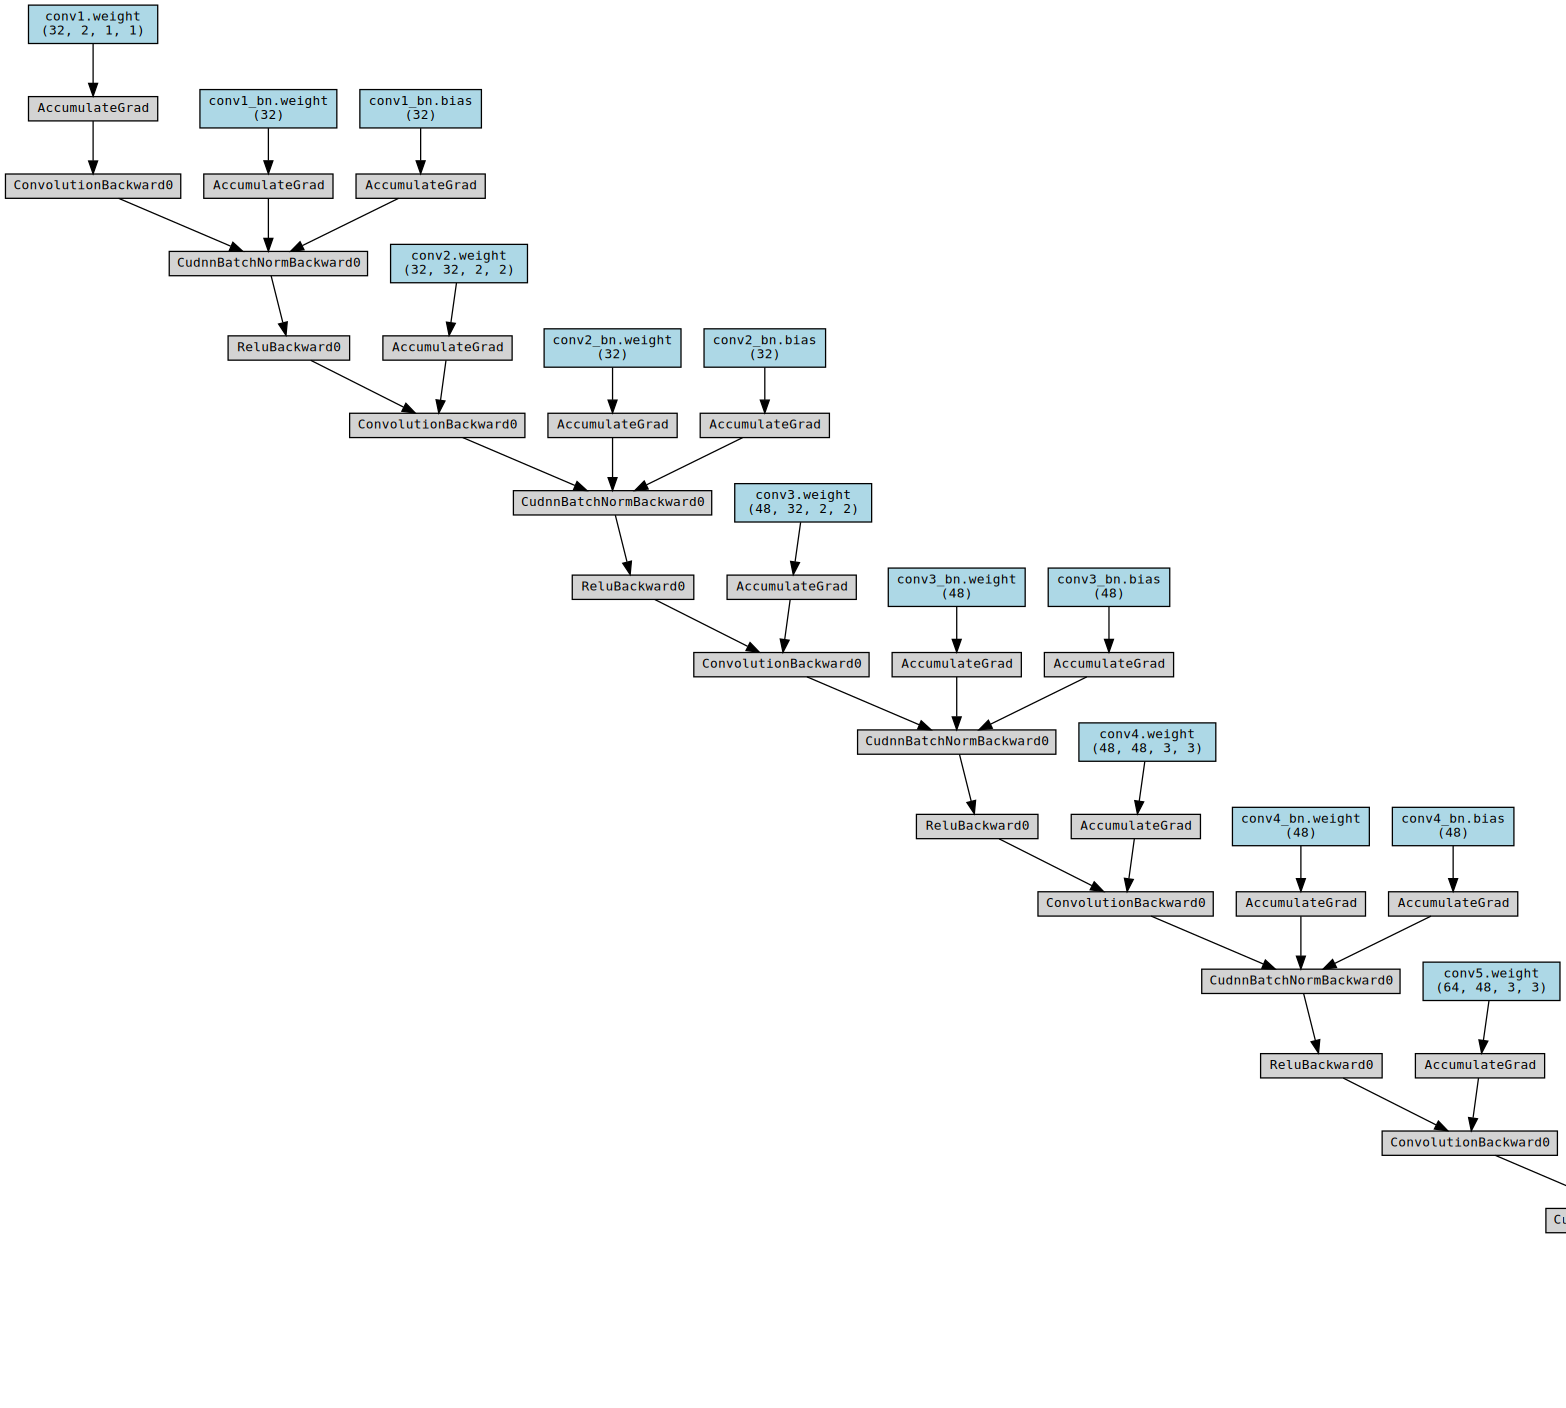

In [ ]:
class ModelV4(nn.Module):
    def __init__(self):
        super(ModelV4, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)

        self.conv5 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)

        self.conv7 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5184, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv5)))
        conv7 = F.relu(self.conv7_bn(self.conv7(conv6)))

        max_pool = self.max_pool(conv7)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelV4()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 31, 31]           4,096
       BatchNorm2d-4           [-1, 32, 31, 31]              64
            Conv2d-5           [-1, 48, 30, 30]           6,144
       BatchNorm2d-6           [-1, 48, 30, 30]              96
            Conv2d-7           [-1, 48, 28, 28]          20,736
       BatchNorm2d-8           [-1, 48, 28, 28]              96
            Conv2d-9           [-1, 64, 26, 26]          27,648
      BatchNorm2d-10           [-1, 64, 26, 26]             128
           Conv2d-11           [-1, 64, 22, 22]         102,400
      BatchNorm2d-12           [-1, 64, 22, 22]             128
           Conv2d-13           [-1, 64, 18, 18]         102,400
      BatchNorm2d-14           [-1, 64,

Epoch 0/24
----------
train Loss: 0.6060 Acc: 0.6776 AUC ROC : 0.7327 Time taken : 108.67
val Loss: 0.5798 Acc: 0.7019 AUC ROC : 0.7708 Time taken : 4.88

Epoch 1/24
----------
train Loss: 0.5688 Acc: 0.7138 AUC ROC : 0.7748 Time taken : 107.34
val Loss: 0.5633 Acc: 0.7186 AUC ROC : 0.7854 Time taken : 4.87

Epoch 2/24
----------
train Loss: 0.5578 Acc: 0.7215 AUC ROC : 0.7859 Time taken : 107.4
val Loss: 0.5514 Acc: 0.7248 AUC ROC : 0.7932 Time taken : 4.84

Epoch 3/24
----------
train Loss: 0.5521 Acc: 0.7258 AUC ROC : 0.7915 Time taken : 107.54
val Loss: 0.5667 Acc: 0.7216 AUC ROC : 0.7907 Time taken : 4.87

Epoch 4/24
----------
train Loss: 0.5476 Acc: 0.7288 AUC ROC : 0.7956 Time taken : 107.17
val Loss: 0.5657 Acc: 0.7176 AUC ROC : 0.7948 Time taken : 4.89

Epoch 5/24
----------
train Loss: 0.5444 Acc: 0.7312 AUC ROC : 0.7987 Time taken : 108.1
val Loss: 0.6367 Acc: 0.6116 AUC ROC : 0.7486 Time taken : 4.86

Epoch 6/24
----------
train Loss: 0.5422 Acc: 0.7328 AUC ROC : 0.8007 Ti

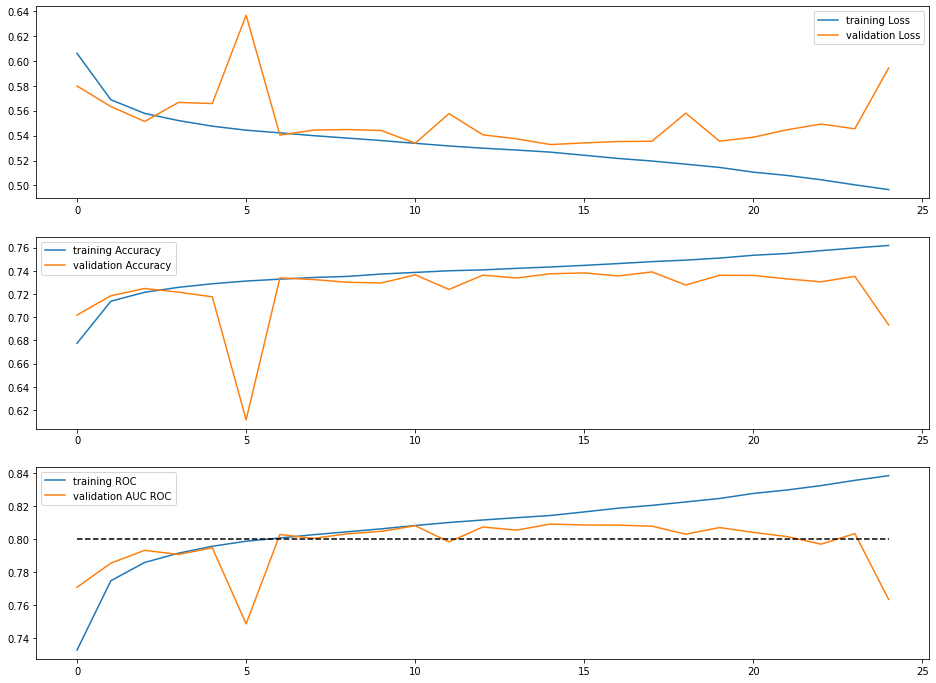

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))
plotResults(res)

Epoch 0/24
----------
train Loss: 0.6109 Acc: 0.6744 AUC ROC : 0.7271 Time taken : 108.69
val Loss: 0.5904 Acc: 0.6926 AUC ROC : 0.7632 Time taken : 5.05

Epoch 1/24
----------
train Loss: 0.5703 Acc: 0.7127 AUC ROC : 0.7733 Time taken : 108.44
val Loss: 0.5642 Acc: 0.7178 AUC ROC : 0.7837 Time taken : 4.98

Epoch 2/24
----------
train Loss: 0.5594 Acc: 0.7209 AUC ROC : 0.7843 Time taken : 108.29
val Loss: 0.6177 Acc: 0.6566 AUC ROC : 0.7538 Time taken : 4.89

Epoch 3/24
----------
train Loss: 0.5534 Acc: 0.7253 AUC ROC : 0.7900 Time taken : 108.1
val Loss: 0.5570 Acc: 0.7212 AUC ROC : 0.7902 Time taken : 4.96

Epoch 4/24
----------
train Loss: 0.5498 Acc: 0.7274 AUC ROC : 0.7934 Time taken : 108.38
val Loss: 0.5527 Acc: 0.7248 AUC ROC : 0.7935 Time taken : 4.88

Epoch 5/24
----------
train Loss: 0.5462 Acc: 0.7293 AUC ROC : 0.7968 Time taken : 108.28
val Loss: 0.5584 Acc: 0.7188 AUC ROC : 0.7985 Time taken : 4.86

Epoch 6/24
----------
train Loss: 0.5433 Acc: 0.7317 AUC ROC : 0.7995 T

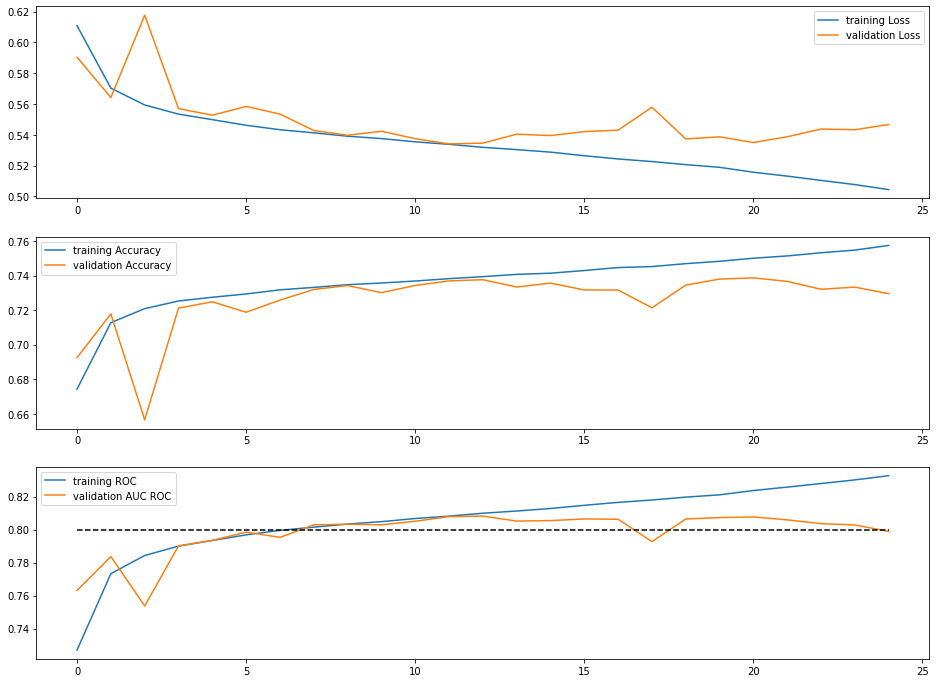

In [ ]:
model_ft = ModelV4()
model_ft = model_ft.to(device)

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))
plotResults(res)

## Maxouts

Change from Relu to something eles

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
           Conv2d-10           [-1, 48, 28, 28]          20,736
      BatchNorm2d-11           [-1, 48, 28, 28]              96
             ReLU-12           [-1, 48, 28, 28]               0
           Conv2d-13           [-1, 64, 26, 26]          27,648
      BatchNorm2d-14           [-1, 64,

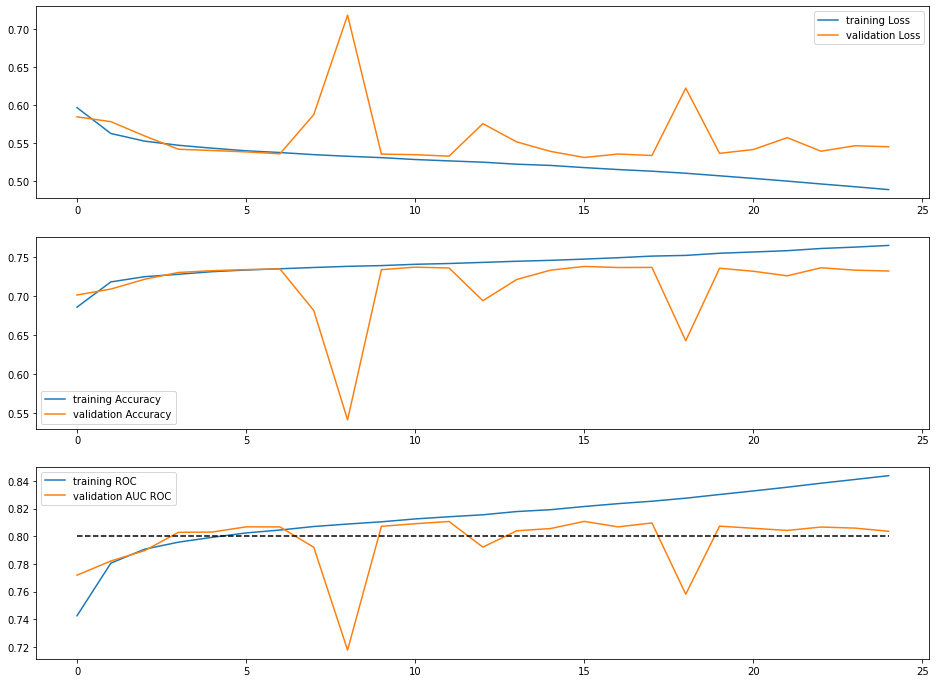

In [ ]:
class ModelV5(nn.Module):
    def __init__(self):
        super(ModelV5, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activation2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)
        self.activation3 = nn.ReLU()

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)
        self.activation4 = nn.ReLU()

        self.conv5 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.activation5 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2)

        self.conv6 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)
        self.activation6 = nn.ReLU()

        self.conv7 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)
        self.activation7 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(1024, 64, bias=False)
        self.activation8 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = self.activation1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))
        conv4 = self.activation4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activation5(self.conv5_bn(self.conv5(conv4)))
        conv5 = self.max_pool1(conv5)
        conv6 = self.activation6(self.conv6_bn(self.conv6(conv5)))
        conv7 = self.activation7(self.conv7_bn(self.conv7(conv6)))
        conv7 = self.max_pool2(conv7)

        flat1 = torch.flatten(conv7.permute(0, 2, 3, 1), 1)
        ret = self.activation8(self.fc1(flat1))
        logits = self.fc2(ret)
        return self.sigmoid(logits)

model_ft = ModelV5()
model_ft = model_ft.to(device)
print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))
plotResults(res)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
           Conv2d-10           [-1, 48, 28, 28]          20,736
      BatchNorm2d-11           [-1, 48, 28, 28]              96
             ReLU-12           [-1, 48, 28, 28]               0
           Conv2d-13           [-1, 64, 24, 24]          76,800
      BatchNorm2d-14           [-1, 64,

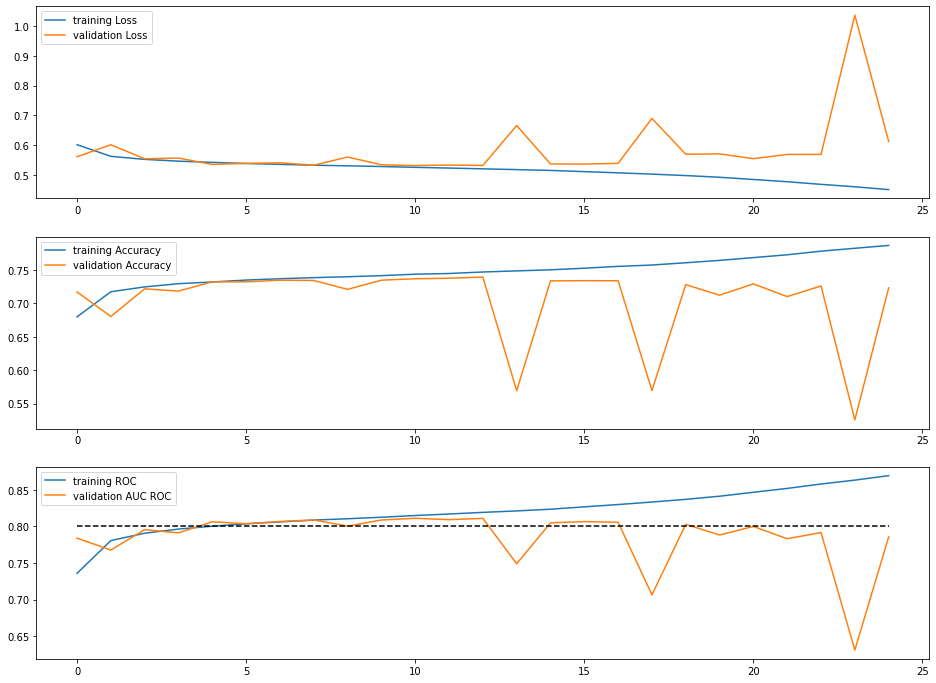

In [ ]:
class ModelV6(nn.Module):
    def __init__(self):
        super(ModelV6, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activation2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)
        self.activation3 = nn.ReLU()

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)
        self.activation4 = nn.ReLU()

        self.conv5 = nn.Conv2d(48, 64, 5, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.activation5 = nn.ReLU()

        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)
        self.activation6 = nn.ReLU()

        self.conv7 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)
        self.activation7 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(4096, 64, bias=False)
        self.activation8 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = self.activation1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))
        conv4 = self.activation4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activation5(self.conv5_bn(self.conv5(conv4)))
        conv6 = self.activation6(self.conv6_bn(self.conv6(conv5)))
        conv7 = self.activation7(self.conv7_bn(self.conv7(conv6)))
        conv7 = self.max_pool2(conv7)

        flat1 = torch.flatten(conv7.permute(0, 2, 3, 1), 1)
        ret = self.activation8(self.fc1(flat1))
        logits = self.fc2(ret)
        return self.sigmoid(logits)

model_ft = ModelV6()
model_ft = model_ft.to(device)
print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))
plotResults(res)

# CNN Ensemble Model

In [ ]:
class smallModelForEnsemble(nn.Module):
    def __init__(self):
        super(smallModelForEnsemble, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activation1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activation2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)
        self.activation3 = nn.ReLU()

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)
        self.activation4 = nn.ReLU()

        self.conv5 = nn.Conv2d(48, 64, 5, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.activation5 = nn.ReLU()

        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)
        self.activation6 = nn.ReLU()

        self.conv7 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)
        self.activation7 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2)

    def forward(self, x):
        conv1 = self.activation1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))
        conv4 = self.activation4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activation5(self.conv5_bn(self.conv5(conv4)))
        conv6 = self.activation6(self.conv6_bn(self.conv6(conv5)))
        conv7 = self.activation7(self.conv7_bn(self.conv7(conv6)))
        conv7 = self.max_pool2(conv7)

        flattened = torch.flatten(conv7.permute(0, 2, 3, 1), 1)
        return flattened


class EnsembleModel(nn.Module):
    def __init__(self, model, n, inp):
        super(EnsembleModel, self).__init__()
        self.models = [model() for _ in range(n)]
        self.logits = nn.Linear(n * self.models[0](inp).shape[-1], 1)
        self.ret_func = nn.Sigmoid()

    def forward(self, x):
        outs = []
        for model in self.models:
            outs.append(model(x))

        layers = torch.cat(outs, dim=-1)
        return self.ret_func(self.logits(layers))


model_ft = EnsembleModel(smallModelForEnsemble, 5, torch.Tensor(1,2,32,32))
model_ft = model_ft.to(device)
for i in range(len(model_ft.models)):
    model_ft.models[i] = model_ft.models[i].to(device)

print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 5e-4)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "EnsembleModel.pth"))
plotResults(res)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]          20,481
           Sigmoid-2                    [-1, 1]               0
Total params: 20,481
Trainable params: 20,481
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.09
----------------------------------------------------------------
None
Epoch 0/24
----------
train Loss: 0.7379 Acc: 0.5800 AUC ROC : 0.6116 Time taken : 451.97
val Loss: 0.6927 Acc: 0.5921 AUC ROC : 0.6593 Time taken : 18.0

Epoch 1/24
----------
train Loss: 0.7178 Acc: 0.6004 AUC ROC : 0.6387 Time taken : 452.72
val Loss: 0.6792 Acc: 0.6134 AUC ROC : 0.6550 Time taken : 17.86

Epoch 2/24
----------
train Loss: 0.7208 Acc: 0.6042 AUC ROC : 0.6444 Time taken : 452.04
val Loss: 1.0371 Acc: 

KeyboardInterrupt: ignored

# Splitted channels

motivated by the fact that the two channels represent different values (in terms of units). Split the channels, make some convolutions and after that combine and output the label


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              32
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 32, 30, 30]           4,096
       BatchNorm2d-8           [-1, 32, 30, 30]              64
              ReLU-9           [-1, 32, 30, 30]               0
           Conv2d-10           [-1, 32, 28, 28]           9,216
      BatchNorm2d-11           [-1, 32, 28, 28]              64
             ReLU-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 32, 26, 26]           9,216
      BatchNorm2d-14           [-1, 32,

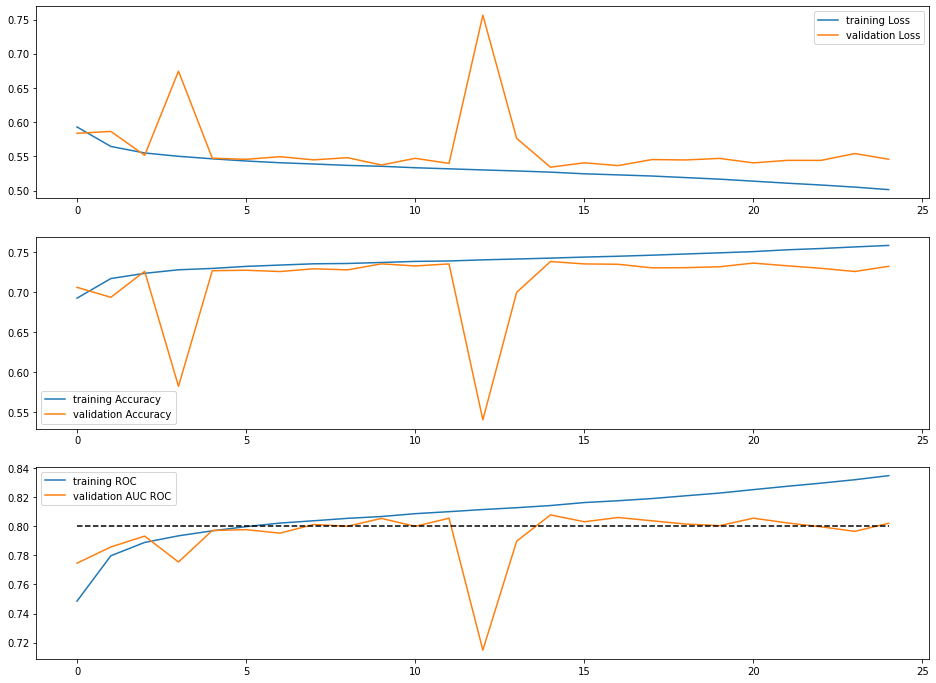

In [ ]:
class modelSingleChannel(nn.Module):
    def __init__(self):
        super(modelSingleChannel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activation2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(32)
        self.activation3 = nn.ReLU()

        self.conv4 = nn.Conv2d(32, 32, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(32)
        self.activation4 = nn.ReLU()

        self.conv5 = nn.Conv2d(32, 32, 3, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(32)
        self.activation5 = nn.ReLU()

    
    def forward(self, x):
        conv1 = self.activation1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))
        conv4 = self.activation4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activation5(self.conv5_bn(self.conv5(conv4)))
        return conv5

class splittedModel(nn.Module):
  def __init__(self):
    super(splittedModel, self).__init__()
    self.time_channels = modelSingleChannel()
    self.energy_channels = modelSingleChannel()

    self.conv1 = nn.Conv2d(64, 64, 3, bias=False)
    self.conv1_bn = nn.BatchNorm2d(64)
    self.activation1 = nn.ReLU()

    self.conv2 = nn.Conv2d(64, 64, 5, bias=False)
    self.conv2_bn = nn.BatchNorm2d(64)
    self.activation2 = nn.ReLU()

    self.conv3 = nn.Conv2d(64, 64, 5, bias=False)
    self.conv3_bn = nn.BatchNorm2d(64)
    self.activation3 = nn.ReLU()

    self.max_pool = nn.MaxPool2d(2)
    self.linear = nn.Linear(4096, 1)
    self.final_activation = nn.Sigmoid()

  def forward(self, x):
    energy, time = x[:, 0, :, :].reshape(-1, 1, 32, 32), x[:, 1, :, :].reshape(-1, 1, 32, 32)
    time_fwd, energy_fwd = self.energy_channels(energy), self.time_channels(time)
    
    combined = torch.cat([time_fwd, energy_fwd], dim=1)
    conv1 = self.activation1(self.conv1_bn(self.conv1(combined)))
    conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
    conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))

    conv3 = self.max_pool(conv3)

    flattened = torch.flatten(conv3.permute(0, 2, 3, 1), 1)

    return self.final_activation(self.linear(flattened))


model_ft = splittedModel()
model_ft = model_ft.to(device)

print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 5e-4)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "EnsembleModel.pth"))
plotResults(res)

# Commonly used layers in CV 
## ConvNeXT

paper and credit https://github.com/facebookresearch/ConvNeXt 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model
from torchsummary import summary

class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)),
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.,
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=3, stride=2),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j],
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)
        self.head_activation = nn.Sigmoid()

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return self.head_activation(x)

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


model_ft = ConvNeXt(in_chans=2, num_classes=1, depths=[2,2,6,2], dims=[32, 64, 64, 96])
model_ft = model_ft.to(device)

print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "EnsembleModel.pth"))
plotResults(res)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             608
         LayerNorm-2           [-1, 32, 15, 15]              64
            Conv2d-3           [-1, 32, 15, 15]             320
         LayerNorm-4           [-1, 15, 15, 32]              64
            Linear-5          [-1, 15, 15, 128]           4,224
              GELU-6          [-1, 15, 15, 128]               0
            Linear-7           [-1, 15, 15, 32]           4,128
          Identity-8           [-1, 32, 15, 15]               0
             Block-9           [-1, 32, 15, 15]               0
           Conv2d-10           [-1, 32, 15, 15]             320
        LayerNorm-11           [-1, 15, 15, 32]              64
           Linear-12          [-1, 15, 15, 128]           4,224
             GELU-13          [-1, 15, 15, 128]               0
           Linear-14           [-1, 15,

# Data normalization

In [9]:
del electronX, electronY
del photonX, photonY

train_size = 0.8
validation_size = 0.1
test_size = 1 - train_size - validation_size

batch_size = 64


model_save_folder = os.path.join(data_filepath, "models")
tensorboard_save_folder = os.path.join(data_filepath, "tensorboard")

photon_filepath = os.path.join(data_filepath, photon_file)
electron_filepath = os.path.join(data_filepath, electron_file)

electronFile = h5py.File(electron_filepath, "r")
photonFile = h5py.File(photon_filepath, "r")

electronX, electronY = np.array(electronFile.get("X")), np.array(electronFile.get('y'))
photonX, photonY     = np.array(photonFile.get("X")),   np.array(photonFile.get('y'))


mean_electron = np.mean(electronX.reshape(-1, 2), axis=0)
std_electron  = np.std(electronX.reshape(-1, 2), axis=0)
electronX = (electronX - mean_electron) / std_electron

mean_photon   = np.mean(photonX.reshape(-1, 2), axis=0)
std_photon    = np.std(photonX.reshape(-1, 2), axis=0)
photonX = (photonX - mean_electron) / std_electron

class PhotonElectronDataset(Dataset):
    def __init__(self, electron_indexes, photon_indexes, transform=None):
        assert len(electron_indexes) == len(photon_indexes)
        self.electron_indexes = electron_indexes
        self.photon_indexes = photon_indexes
        self.transform = transform

    def __len__(self):
        return len(self.electron_indexes) + len(self.photon_indexes)

    def __getitem__(self, idx):
        #image = torch.from_numpy(self.X[idx, :, :, :])

        # photon if even
        if idx % 2 == 0:
            image = photonX[self.photon_indexes[idx // 2], :, :, :]
            label = photonY[self.photon_indexes[idx // 2]]
        # electron if odd
        else:
            image = electronX[self.electron_indexes[idx // 2], :, :, :]
            label = electronY[self.electron_indexes[idx // 2]]

        if self.transform:
            image = self.transform(image)
        return image, label

nElectronImgs = len(electronFile["X"])
nPhotonImgs = len(photonFile['y'])

electrons_idxs = np.arange(0, nElectronImgs)
np.random.shuffle(electrons_idxs)

photon_idxs = np.arange(0, nPhotonImgs)
np.random.shuffle(photon_idxs)

electron_training_idxs   = electrons_idxs[0: int(train_size * nElectronImgs)]
electron_validation_idxs = electrons_idxs[int(train_size * nElectronImgs) : int((train_size + validation_size) * nElectronImgs)]
electron_test_idxs       = electrons_idxs[int((train_size + validation_size) * nElectronImgs) :]

photon_training_idxs   = photon_idxs[0: int(train_size * nElectronImgs)]
photon_validation_idxs = photon_idxs[int(train_size * nElectronImgs) : int((train_size + validation_size) * nElectronImgs)]
photon_test_idxs       = photon_idxs[int((train_size + validation_size) * nElectronImgs) :]


training_dataset = PhotonElectronDataset(electron_training_idxs, photon_training_idxs, transform=transforms.Compose([transforms.ToTensor()]))
validation_dataset  = PhotonElectronDataset(electron_validation_idxs, photon_validation_idxs, transform=transforms.Compose([transforms.ToTensor()]))
testing_dataset  = PhotonElectronDataset(electron_test_idxs, photon_test_idxs, transform=transforms.Compose([transforms.ToTensor()]))

training_ds_size = len(training_dataset)
validation_ds_size = len(validation_dataset)
testing_ds_size = len(testing_dataset)

print(f"training size : {training_ds_size}")
print(f"validation size : {validation_ds_size}")
print(f"testing size : {testing_ds_size}")

train_dataloader      = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader       = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

training size : 398400
validation size : 49800
testing size : 49800


In [10]:
electronX[0]

array([[[-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        ...,
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ]],

       [[-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        ...,
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ]],

       [[-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        ...,
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ]],

       ...,

       [[-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        ...,
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ],
        [-0.05160015,  0.0040904 ]],

       [[-0.05160015,  0.0040904 ],
        [-0.05160015,  0.00

In [ ]:
class ModelV5(nn.Module):
    def __init__(self):
        super(ModelV5, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activation2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)
        self.activation3 = nn.ReLU()

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)
        self.activation4 = nn.ReLU()

        self.conv5 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.activation5 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2)

        self.conv6 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)
        self.activation6 = nn.ReLU()

        self.conv7 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)
        self.activation7 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(1024, 64, bias=False)
        self.activation8 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = self.activation1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))
        conv4 = self.activation4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activation5(self.conv5_bn(self.conv5(conv4)))
        conv5 = self.max_pool1(conv5)
        conv6 = self.activation6(self.conv6_bn(self.conv6(conv5)))
        conv7 = self.activation7(self.conv7_bn(self.conv7(conv6)))
        conv7 = self.max_pool2(conv7)

        flat1 = torch.flatten(conv7.permute(0, 2, 3, 1), 1)
        ret = self.activation8(self.fc1(flat1))
        logits = self.fc2(ret)
        return self.sigmoid(logits)

model_ft = ModelV5()
model_ft = model_ft.to(device)
print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))
plotResults(res)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
           Conv2d-10           [-1, 48, 28, 28]          20,736
      BatchNorm2d-11           [-1, 48, 28, 28]              96
             ReLU-12           [-1, 48, 28, 28]               0
           Conv2d-13           [-1, 64, 26, 26]          27,648
      BatchNorm2d-14           [-1, 64,

# Vision Transformer

# Graph Neural Network